# Demo of `secop-ophyd` Integration 

This demo utilizes the samplechanger SEC node, and demonstrates the concurrent control and readout of EPICS Detectors and SECoP hardware.

prerequisites:
- a running instance ofURsim (see `/URsimDocker` directory) or the real UR3 robot samplechanger apparatus

- `remote mode`of the robot has to be enabled 
    
- a running SEC node for the samplechanger robot is needed as well:
    ```python3 frappy/bin/frappy-server -c frappy/cfg/UR_robot_cfg.py``` 


### Bluesky Runenegine Setup

In [1]:
from databroker.v2 import temp
from bluesky import RunEngine, Msg
import bluesky.plan_stubs as bps

import bluesky.preprocessors as bpp

from secop_ophyd.SECoPDevices import SECoP_Node_Device, SECoPReadableDevice, SECoPMoveableDevice, SECoP_CMD_Device

import random

from ophyd.sim import  SynGauss, motor

noisy_det0 = SynGauss(
        "noisy_det0",
        motor,
        "motor",
        center=1,
        Imax=1,
        noise="uniform",
        sigma=1,
        noise_multiplier=0.4,
        labels={"detectors"},
    )

noisy_det1 = SynGauss(
        "noisy_det1",
        motor,
        "motor",
        center=0.5,
        Imax=1,
        noise="uniform",
        sigma=1,
        noise_multiplier=1,
        labels={"detectors"},
    )

noisy_det2 = SynGauss(
        "noisy_det2",
        motor,
        "motor",
        center=0,
        Imax=1,
        noise="uniform",
        sigma=1,
        noise_multiplier=3,
        labels={"detectors"},
    )





# Create a run engine and a temporary file backed database. Send all the documents from the RE into that database
RE = RunEngine({})
db = temp()
RE.subscribe(db.v1.insert)





#Example of adding metadata to RE environment
investigation_id = "kmnk2n34"

RE.md["investigation_id"] = investigation_id



Extend DSO search path to '/home/qfj/git-repos/secop-ophyd/.venv/lib/python3.10/site-packages/epicscorelibs/lib'
first instance of OphydObject: id=139723231380576
put(value=0, timestamp=None, force=False, metadata=None)
put(value=0, timestamp=None, force=False, metadata=None)
put(value=1, timestamp=None, force=False, metadata=None)
put(value=1, timestamp=None, force=False, metadata=None)
put(value=2, timestamp=None, force=False, metadata=None)
put(value=0.1, timestamp=None, force=False, metadata=None)
put(value=1.0046674508478093, timestamp=None, force=False, metadata=None)
put(value=0, timestamp=None, force=False, metadata=None)
put(value=0, timestamp=None, force=False, metadata=None)
put(value=1, timestamp=None, force=False, metadata=None)
put(value=1, timestamp=None, force=False, metadata=None)
put(value=1.0, timestamp=None, force=False, metadata=None)
put(value=0, timestamp=None, force=False, metadata=None)
put(value=0, timestamp=None, force=False, metadata=None)
put(value=1, times

### SECoP-Ophyd Device generation

In [2]:


# Connect to SEC Node and generate ophyd device tree
robo_dev = await SECoP_Node_Device.create('localhost','10770',RE.loop)


#One Device for every Robot SECoP Module 
storage:SECoPReadableDevice= robo_dev.storage
sample:SECoPMoveableDevice= robo_dev.sample
robot:SECoPMoveableDevice= robo_dev.robot

#Devices for SECoP Commands
loadshort:SECoP_CMD_Device = storage.load_short_CMD
measure:SECoP_CMD_Device = sample.measure_CMD


sample_changer.HZB ready


### Populating the Storage Module

Samples of random substance are loaded into the storage module  

In [3]:



SCHOKO_SORTEN = {
    0:'Knusperkeks',
    1:'Edel-Vollmilch',
    2:'Knusperflakes',
    3:'Nuss-Splitter',
    4:'Nugat',
    5:'Marzipan',
    6:'Joghurt',
}



# Example Plan for loading samples into the robot
def load_samples(storage, lower, upper):
    loadshort:SECoP_CMD_Device = storage.load_short_CMD

    for samplepos in range(lower,upper):
        
        ### populate Command arguments
        
        # set substance of sample
        substance = random.randint(0,6)
        yield from bps.abs_set(loadshort.argument,{'substance':substance,'samplepos':samplepos}, group='sample')         


        ## wait for arguments to be set (should be instant because command args are locally saved dummy signals)
        yield from bps.wait('sample')
        

        # Trigger command execution of _load_short command
        yield from bps.trigger(loadshort,wait=True)        

        print( 'A \'' + SCHOKO_SORTEN[substance] + '\' sample has been loaded into position '+ str(samplepos) + '.')



## loading random samples
RE(load_samples(storage,1,4))
        

Executing plan <generator object load_samples at 0x7f13d98f99a0>
Change state on <bluesky.run_engine.RunEngine object at 0x7f141a3769e0> from 'idle' -> 'running'
set(<ophyd_async.core.signal.SignalRW object at 0x7f13d9876ef0>, *({'substance': 4, 'samplepos': 1},) **{'group': 'sample'}, run=None)
wait(None, *() **{'group': 'sample', 'timeout': None}, run=None)
The object <ophyd_async.core.signal.SignalRW object at 0x7f13d9876ef0> reports set is done with status True
trigger(<secop_ophyd.SECoPDevices.SECoP_CMD_Device object at 0x7f13d9876ec0>, *() **{'group': None}, run=None)
wait(None, *() **{'group': None}, run=None)
The object <secop_ophyd.SECoPDevices.SECoP_CMD_Device object at 0x7f13d9876ec0> reports 'trigger' is done with status True.
A 'Nugat' sample has been loaded into position 1.
set(<ophyd_async.core.signal.SignalRW object at 0x7f13d9876ef0>, *({'substance': 0, 'samplepos': 2},) **{'group': 'sample'}, run=None)
wait(None, *() **{'group': 'sample', 'timeout': None}, run=None)
T

()

### Making a Measurement (`_measure()` Command)

Here a simulated EPICS detector is read while the SECoP `_measure()` Command is running. 

In [4]:
def measure(sample,sample_num):

    ## Sample Check
    # check if robot is currently holding a sample and 
    # put it back into storage if its not th correct one    
    reading = yield from bps.read(sample)
  
    curr_sample = reading[sample.value.name]['value']
    
    # holding wrong sample -->  put it back into storage
    if curr_sample != 0 and curr_sample  != sample_num :
        yield from bps.mv(sample,0)
    
    # gripper empty --> grab correct sample
    if curr_sample == 0:
        print('grabbing sample: '+str(i))
        yield from bps.mv(sample,i)
    
    print('holding sample: '+str(i))
    
    @bpp.run_decorator()
    def inner_meas(sample):
        
          
        complete_status = yield from bps.trigger(sample.measure_CMD, wait=False) #This message doesn't exist yet
        print('starting measurement')
        
        # While the device is still executing, read from the detectors in the detectors list
        while not complete_status.done:

            yield Msg('checkpoint') # allows us to pause the run 
            
            yield from bps.one_shot([noisy_det0,noisy_det1,noisy_det2]) #triggers and reads everything in the detectors list
           
           
            yield Msg('sleep', None, 1)       
        
        print('measurement done')
            
      
    ### Do actual measurement ###
    uid = yield from inner_meas(sample)

 
    # put sample back into storage
    print('putting back sample: '+str(i))
    yield from  bps.mv(sample,0)

    return uid




for i in range(1,4):
    #grab sample i and hold in Measurement Pos
    RE(measure(sample,i))
    


Executing plan <generator object measure at 0x7f13d98fa810>
Change state on <bluesky.run_engine.RunEngine object at 0x7f141a3769e0> from 'idle' -> 'running'
read(<secop_ophyd.SECoPDevices.SECoPMoveableDevice object at 0x7f13d9877550>, *() **{}, run=None)
grabbing sample: 1
set(<secop_ophyd.SECoPDevices.SECoPMoveableDevice object at 0x7f13d9877550>, *(1,) **{'group': 'fce0e71b-c464-4ddc-a150-3509ceddba91'}, run=None)
wait(None, *() **{'group': 'fce0e71b-c464-4ddc-a150-3509ceddba91'}, run=None)
The object <secop_ophyd.SECoPDevices.SECoPMoveableDevice object at 0x7f13d9877550> reports set is done with status True
holding sample: 1
open_run(None, *() **{}, run=None)
[start] document is emitted (run_uid='7ecc9b1c-bb8d-4184-8822-d6c5f355571e')
trigger(<secop_ophyd.SECoPDevices.SECoP_CMD_Device object at 0x7f13d8691150>, *() **{'group': None}, run=None)
starting measurement
checkpoint(None, *() **{}, run=None)
checkpoint(None, *() **{}, run=None)
trigger(SynGauss(prefix='', name='noisy_det0',

The object SynGauss(prefix='', name='noisy_det0', read_attrs=['val'], configuration_attrs=['Imax', 'center', 'sigma', 'noise', 'noise_multiplier']) reports 'trigger' is done with status True.
The object SynGauss(prefix='', name='noisy_det1', read_attrs=['val'], configuration_attrs=['Imax', 'center', 'sigma', 'noise', 'noise_multiplier']) reports 'trigger' is done with status True.
The object SynGauss(prefix='', name='noisy_det2', read_attrs=['val'], configuration_attrs=['Imax', 'center', 'sigma', 'noise', 'noise_multiplier']) reports 'trigger' is done with status True.
The object SynGauss(prefix='', name='noisy_det0', read_attrs=['val'], configuration_attrs=['Imax', 'center', 'sigma', 'noise', 'noise_multiplier']) reports 'trigger' is done with status True.
The object SynGauss(prefix='', name='noisy_det1', read_attrs=['val'], configuration_attrs=['Imax', 'center', 'sigma', 'noise', 'noise_multiplier']) reports 'trigger' is done with status True.
The object SynGauss(prefix='', name='noi

### Plotting Detector data for the most recent Sample

Loaded BlueskyRunFromGenerator named '0bd8ba2e-1b32-4ef9-a299-769bc849ef2d'
Created BlueskyRunFromGenerator named '0bd8ba2e-1b32-4ef9-a299-769bc849ef2d'
Created Entry named 'primary'
Loaded BlueskyEventStream for stream name 'primary'
Created BlueskyEventStream for stream name 'primary'
Loaded BlueskyEventStream for stream name 'primary'


/home/qfj/git-repos/secop-ophyd/.venv/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/qfj/git-repos/secop-ophyd/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/qfj/git-repos/secop-ophyd/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
findfont: score(FontEntry(fname='/home/qfj/git-repos/secop-ophyd/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf', name='STIXGeneral', style='normal', variant='normal', weight=700, stretch=

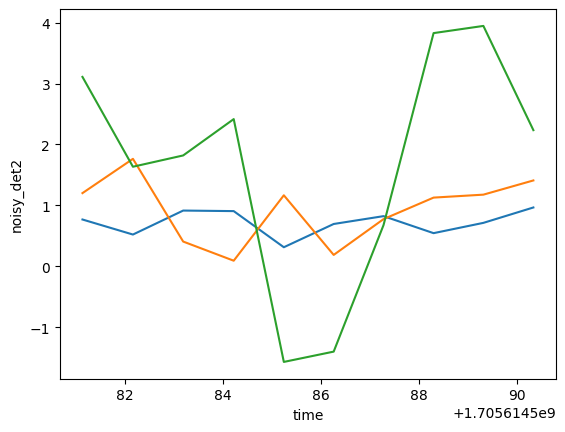

In [5]:

run=db[-1]
data = run.primary.read()
data["noisy_det0"].plot()
data["noisy_det1"].plot()
data["noisy_det2"].plot()
